In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14,8
plt.style.use('ggplot')
import seaborn as sns
kk =sns.color_palette()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as MAE # MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score # R2
import pickle
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
df = pd.read_csv('bit1.csv', sep=';')
df = df.set_index('date')
df = df.sort_index()

In [ ]:
Y = df['price']
trend = Y.rolling(window = 10).mean().dropna()

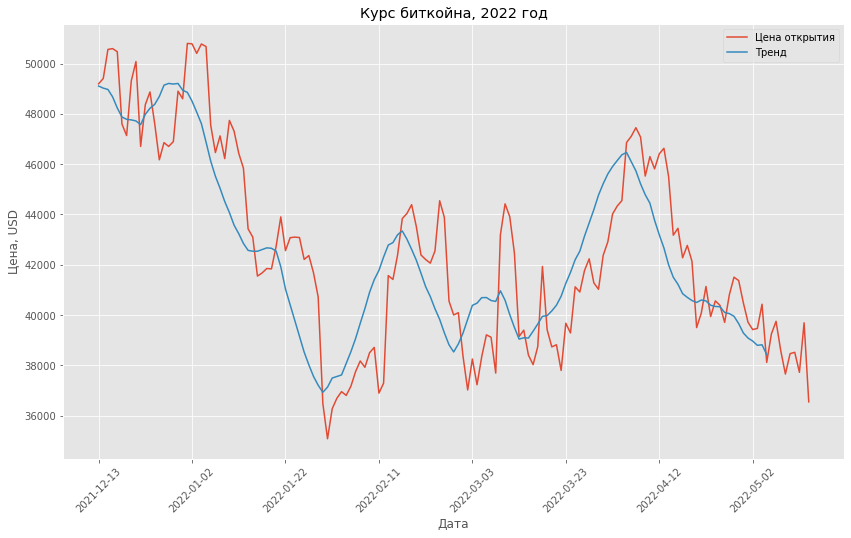

In [75]:
Y.plot(subplots=True, color=kk[0], label='Цена открытия')
plt.title('Курс биткойна, 2022 год');
plt.ylabel('Цена, USD');
trend.plot(color=kk[1], label='Тренд');
plt.legend();
plt.xticks(rotation=45);

In [ ]:
news = pd.read_csv('news.csv', sep=';')

In [84]:
news['text'].to_csv('news.txt', index=False)

In [ ]:
n1 = news.copy()
n1['text'] = 1

In [123]:
n2 = n1.groupby('date').sum()
N2 = n2.rolling(window = 15).mean()
n2['Тренд'] = N2['text']
n2['Новости'] = n2['text']
n2 = n2.drop(['text'], axis=1)

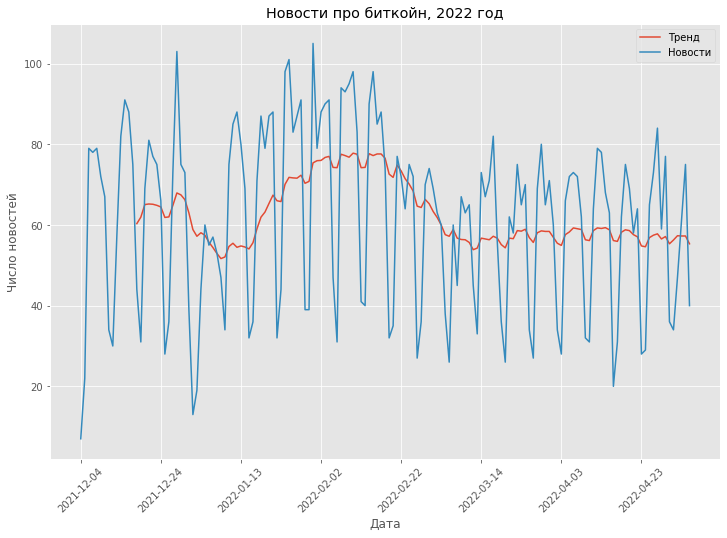

In [125]:
n2.plot(label='Новости');
plt.title('Новости про биткойн, 2022 год');
plt.xlabel('Дата');
plt.ylabel('Число новостей');
plt.xticks(rotation=45);
plt.legend();

In [144]:
f = open('data.pickle', 'rb')
res = pickle.load(f)

In [176]:
rr1 = []
rr2 = []
rr3 = []
rr4 = []
for i,d in enumerate(res):
    r1 = 0.0
    r2 = 0.0
    r3 = 0.0
    r4 = 0.0
    if 'negative' in d:
        r1 = d['negative']
    if 'neutral' in d:
        r2 = d['neutral']
    if 'positive' in d:
        r3 = d['positive']
    if 'skip' in d:
        r4 += d['skip']
    rr1 += [r1]
    rr2 += [r2]
    rr3 += [r3]
    rr4 += [r4]

In [177]:
out = pd.DataFrame({'negative': rr1, 'neutral': rr2, 'positive': rr3, 'skip': rr4})

In [179]:
out.to_csv('santiment.csv', index=False)
out.to_excel('santiment.xlsx', index=False)

In [287]:
out['res'] = -1 * out['negative'] + 1 * out['positive']

In [ ]:
n1['res'] = out['res']

In [ ]:
n5 = n1.groupby('date').mean()['res']

In [217]:
import re
df = pd.read_csv('bit1.csv', sep=';')
df = df.set_index('date')
df = df.sort_index()
def toi(x):
    x = re.sub(',\d+', '', x)
    x = int(x)
    return x
def vol(x):
    x = re.sub(',\d+', '', x)
    t = re.sub('\d+', '', x)
    x = re.sub('\D', '', x)
    x = int(x)
    if t == 'K':
        x *= 10**3
    elif t == 'M':
        x *= 10**6
    elif t == 'B':
        x *= 10**9
    else:
        print('err', x, t)
    return x
df['open'] = df['open'].apply(lambda x: toi(x))
df['max'] = df['max'].apply(lambda x: toi(x))
df['min'] = df['min'].apply(lambda x: toi(x))
df['vol'] = df['vol'].apply(lambda x: vol(x))

In [ ]:
df1 = pd.DataFrame()
df1['v1'] = df['price'] - df['open'] 
df1['v2'] = df['max'] - df['min'] 
df1['vol'] = df['vol']

In [229]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [ ]:
X1 = df1.copy()
y = pd.DataFrame(df['price'])
ss1 = StandardScaler()
X1_ss = ss1.fit_transform(X1)
mm = MinMaxScaler()
y_mm = mm.fit_transform(y)
y_train = y_mm[:120, :]
y_train = torch.Tensor(y_train)
X1_train = X1_ss[:120, :]
X1_train = torch.Tensor(X1_train)
N1, N2 = X1_train.shape
X1_train = torch.reshape(X1_train, (N1, 1, N2))

In [3]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.relu(x)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        return x  
    
input_size = 3 
hidden_size = 2
num_layers = 2 
lstm1 = LSTM1(input_size, hidden_size, num_layers) 
learning_rate = 0.001
criterion = torch.nn.MSELoss() 
optimizer1 = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [ ]:
num_epochs = 1000
ll1 = []
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train)
    optimizer1.zero_grad() 
    loss = criterion(outputs, y_train)
    loss.backward() 
    optimizer1.step() 
    ll1 += [loss.item()]
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

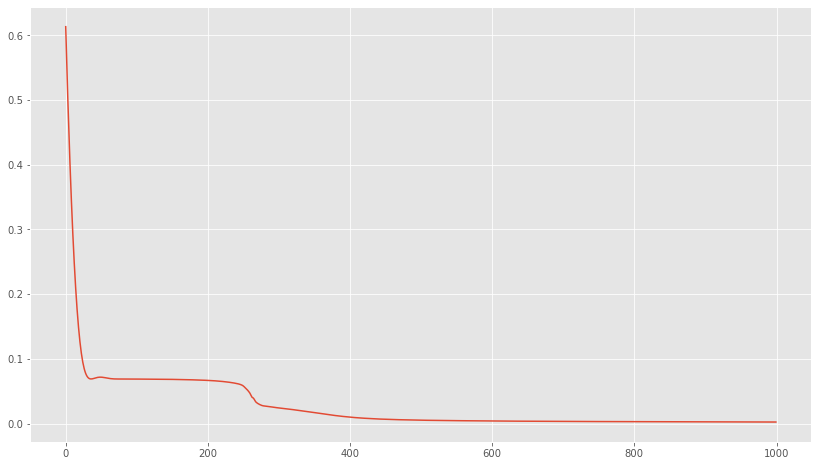

In [377]:
plt.plot(ll1);

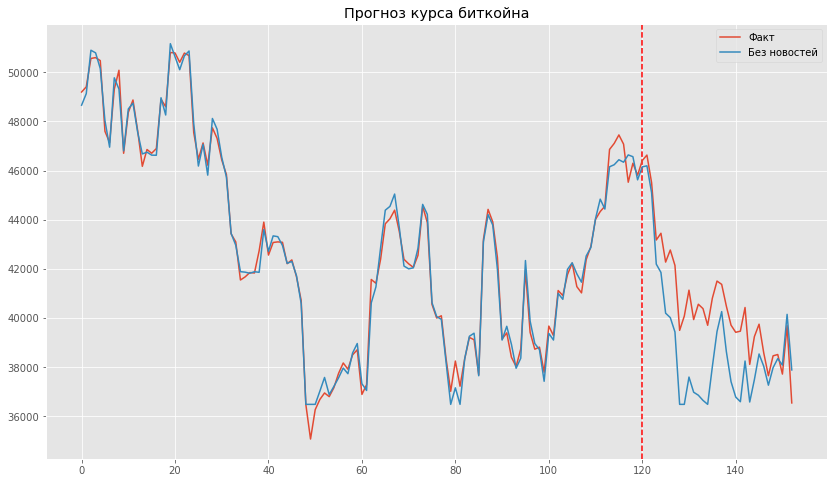

In [382]:
X1 = df1.copy()
X1 = ss1.transform(X1)
X1 = torch.Tensor(X1)
N1, N2 = X1.shape
X1 = torch.reshape(X1, (N1, 1, N2))
predict1 = lstm1(X1) 
predict1 = predict1.detach().numpy() 
predict1 = mm.inverse_transform(predict1)
plt.axvline(x=120, c='r', linestyle='--');
plt.plot(y1.values, label='Факт') 
plt.plot(predict1, label='Без новостей') 
plt.title('Прогноз курса биткойна')
plt.legend();

In [ ]:
X2 = df2.copy()
X2['res'] = n5
X2

In [ ]:
ss2 = StandardScaler()
X2 = df2.copy()
X2['res'] = n5
X2_ss = ss2.fit_transform(X2)
X2_train = X2_ss[:120, :]
X2_train = torch.Tensor(X2_train)
N1, N2 = X2_train.shape
X2_train = torch.reshape(X2_train, (N1, 1, N2))
print(X2_train.shape)

In [ ]:
class LSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.relu(x)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        return x  
    
input_size = 4 
hidden_size = 2 
num_layers = 2
lstm2 = LSTM2(input_size, hidden_size, num_layers) 
learning_rate = 0.001
criterion = torch.nn.MSELoss() 
optimizer2 = torch.optim.Adam(lstm2.parameters(), lr=learning_rate) 

In [368]:
num_epochs = 1000
ll2 = []
for epoch in range(num_epochs):
    outputs = lstm2.forward(X2_train)
    optimizer2.zero_grad() 
    loss = criterion(outputs, y_train)
    loss.backward() 
    optimizer2.step() 
    ll2 += [loss.item()]
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.33855
Epoch: 100, loss: 0.06800
Epoch: 200, loss: 0.05581
Epoch: 300, loss: 0.04378
Epoch: 400, loss: 0.01292
Epoch: 500, loss: 0.00464
Epoch: 600, loss: 0.00329
Epoch: 700, loss: 0.00268
Epoch: 800, loss: 0.00226
Epoch: 900, loss: 0.00192


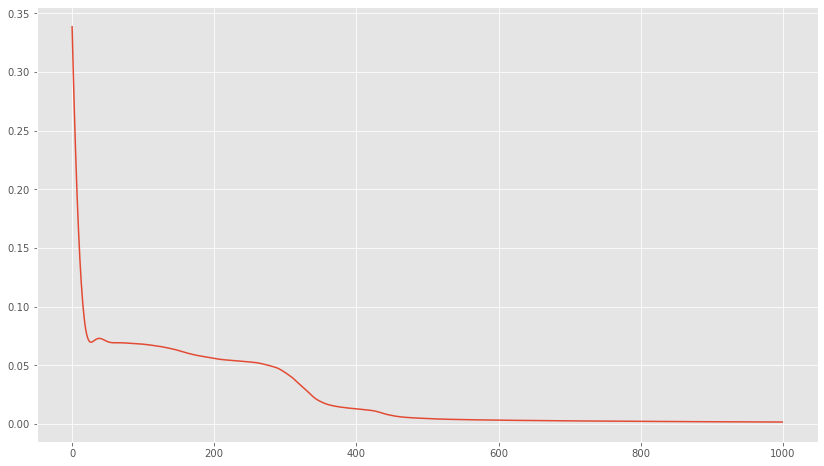

In [369]:
plt.plot(ll2);

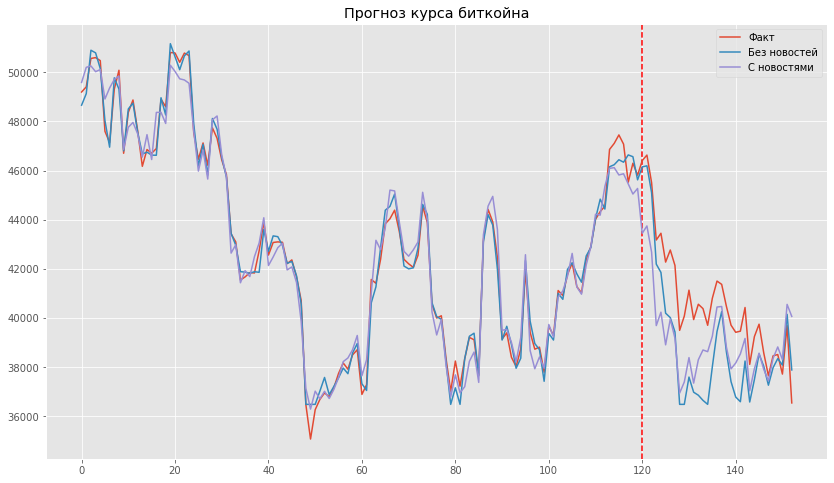

In [384]:
X1 = df1.copy()
X2 = df2.copy()
X2['res'] = n5
y1 = pd.DataFrame(df['price'])
X1 = ss1.transform(X1)
X2 = ss2.transform(X2)
X1 = torch.Tensor(X1)
X2 = torch.Tensor(X2)
N1, N2 = X1.shape
X1 = torch.reshape(X1, (N1, 1, N2))
N1, N2 = X2.shape
X2 = torch.reshape(X2, (N1, 1, N2))
predict1 = lstm1(X1) 
predict2 = lstm2(X2) 
predict1 = predict1.detach().numpy() 
predict2 = predict2.detach().numpy() 
predict1 = mm.inverse_transform(predict1)
predict2 = mm.inverse_transform(predict2)
plt.axvline(x=120, c='r', linestyle='--');
plt.plot(y1.values, label='Факт') 
plt.plot(predict1, label='Без новостей') 
plt.plot(predict2, label='С новостями') 
plt.title('Прогноз курса биткойна')
plt.legend();

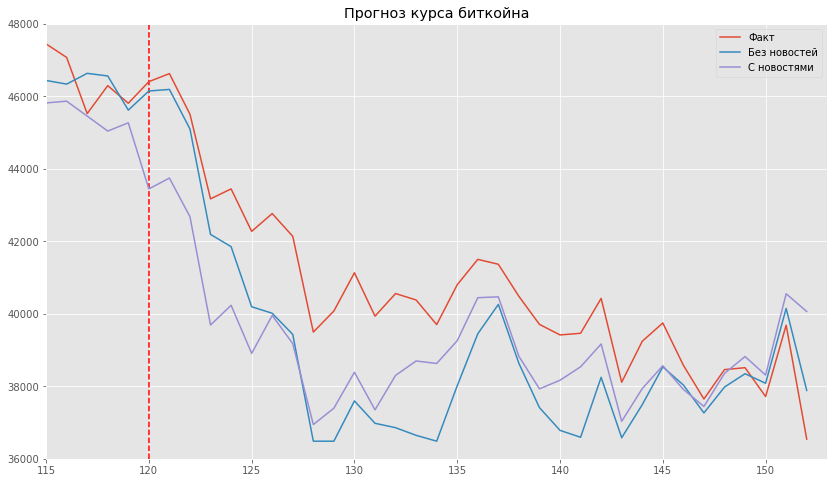

In [418]:
plt.axvline(x=120, c='r', linestyle='--');
plt.plot(y1.values, label='Факт') 
plt.plot(predict1, label='Без новостей') 
plt.plot(predict2, label='С новостями') 
plt.title('Прогноз курса биткойна')
plt.legend();
plt.xlim(115,153);
plt.ylim(36000,48000);

In [383]:
pp11 = predict1
pp21 = predict2
Y1 = y1.values

In [396]:
y2 = Y1[120:]
y2.shape

(33, 1)

In [399]:
pp12 = pp11[120:]
pp12.shape

(33, 1)

In [407]:
pp22 = pp21[120:]
pp22.shape

(33, 1)

In [408]:
MAE(y2, pp12)

1847.8357007575758

In [409]:
MAE(y2, pp22)

1826.5228456439395

In [410]:
mean_squared_error(y2, pp12, squared=False)

2173.608843517566

In [411]:
mean_squared_error(y2, pp22, squared=False)

2096.6717511986844

In [412]:
r2_score(y2, pp12)

0.14697980097210284

In [413]:
r2_score(y2, pp22)

0.2062981031804889

In [419]:
(1847-1826)/1826

0.011500547645125958

In [420]:
(2173-2096)/2096

0.036736641221374045